# Inverted pendulum on cart model

Equations:

$$
\begin{cases}
\ddot{x} + \alpha\cos\theta\,\ddot{\theta} + \alpha\sin\theta\,\dot{\theta}^2 &= u \\
-\cos\theta\,\ddot{x} + \ddot{\theta} &= \sin\theta
\end{cases},
$$

where $\alpha < 1$ is the ratio of the pendulum mass over the total system mass.

We now define the system dynamics in CasADi

In [1]:
import horizon.solvers.ilqr as ilqr
import casadi as cs
import numpy as np

# switch between MX and SX
sym_t = cs.MX

# define state
q = sym_t.sym('q', 2)
qdot = sym_t.sym('qdot', 2)
x = cs.vertcat(q, qdot)
u = sym_t.sym('u', 1)
theta = q[1]
thetadot = qdot[1]

# system parameters
alpha = 0.5  # pendulum mass over total mass ratio

Binv = sym_t(2, 2)  # inverse inertia matrix
Binv[0, 0] = 1
Binv[0, 1] = -alpha
Binv[1, 1] = 1
Binv[1, 0] = cs.cos(theta)
Binv = Binv / (1 + alpha*cs.cos(theta))

# forward dynamics
qddot = Binv @ cs.vertcat(u - alpha*cs.sin(theta)*thetadot**2,
                          cs.sin(theta))

# state transition
xdot = cs.vertcat(qdot,
                  qddot)

## Optimal control problem

We optimize the following cost
$$
    J(\boldsymbol{x}_0, \mathbf{U}) = \int_0^{t_f} u^2 \,\text{d}t \; + \; 1000\cdot\lVert \boldsymbol{x}_N - \boldsymbol{x}_f^\text{ref}  \rVert^2
$$

discretized with $N$ knots of duration $\text{d}t$.

In [2]:
N = 200  # number of nodes
dt = 0.05  # discretizaton step
niter = 20  # ilqr iterations
xf = np.array([0, 0, 0, 0])  # desired final state (upright)
x0 = np.array([0, 3.1415, 0, 0])  # initial state (falling)

l = cs.dot(u, u)  # intermediate cost
lf = 1000*cs.dot(x - xf, x - xf)  # final cost

Costs and dynamics must be expressed as CasADi functions

In [3]:
L = cs.Function('intermediate_cost',
                {'x': x, 'u': u, 'l': l},
                ['x', 'u'],
                ['l']
                )

Xdot = cs.Function('dynamics',
                {'x': x, 'u': u, 'xdot': xdot},
                ['x', 'u'],
                ['xdot']
                )


Lf = cs.Function('final_cost',
                {'x': x, 'l': lf},
                ['x'],
                ['l']
                )


solver = ilqr.IterativeLQR(xdot=Xdot,
                           dt=dt,
                           N=N,
                           diff_intermediate_cost=L,
                           final_cost=Lf)

solver.setInitialState(x0)
solver.solve(niter)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

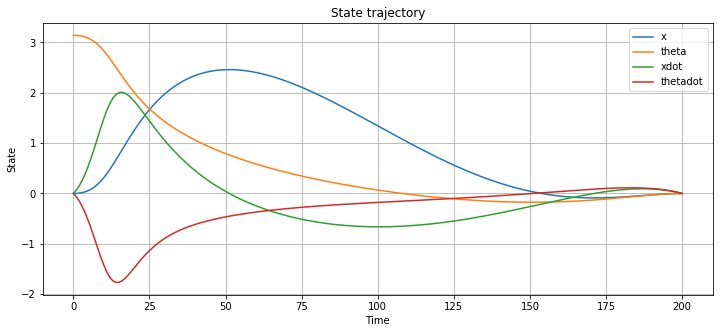

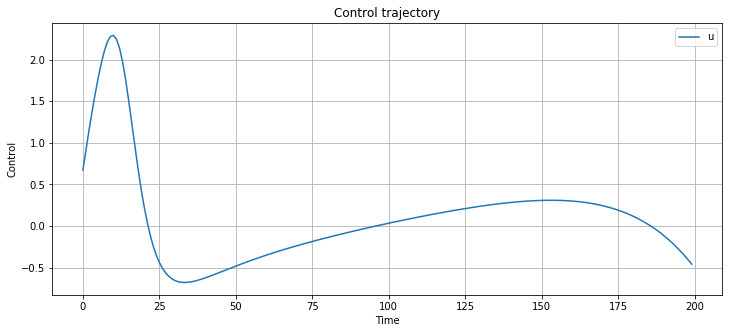

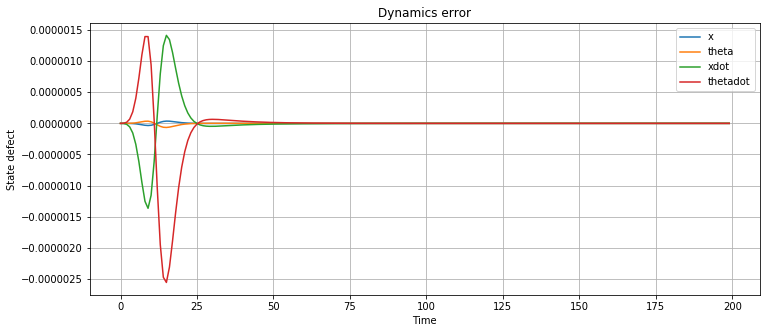

In [5]:
plt.figure(figsize=[12, 5])
lines = plt.plot(solver._state_trj)
plt.title('State trajectory')
plt.xlabel('Time')
plt.ylabel('State')
plt.grid()
plt.legend(lines, ['x', 'theta', 'xdot', 'thetadot'])

plt.figure(figsize=[12, 5])
lines = plt.plot(solver._ctrl_trj)
plt.title('Control trajectory')
plt.xlabel('Time')
plt.ylabel('Control')
plt.grid()
plt.legend(lines, ['u'])

plt.figure(figsize=[12, 5])
lines = plt.plot(solver._defect)
plt.title('Dynamics error')
plt.xlabel('Time')
plt.ylabel('State defect')
plt.grid()
plt.legend(lines, ['x', 'theta', 'xdot', 'thetadot'])


## ROS visualization
The following code visualizes the result in RViz. In separate terminals, open RViz and the Robot State Publisher

In [17]:
import rospy
import sensor_msgs.msg
import math

rospy.init_node('inv_pendulum_joint_publisher')

with open('inv_pendulum.urdf', 'r') as urdf_file:
    urdf = urdf_file.read()
    rospy.set_param('robot_description', urdf)
    
js_pub = rospy.Publisher('joint_states', sensor_msgs.msg.JointState, queue_size=1)

l = 1.0
g = 9.8
real_dt = dt * math.sqrt(l/g)
rate = rospy.Rate(1./real_dt)

for _ in range(15):
    
    for i in range(N+1):
    
        msg = sensor_msgs.msg.JointState()
        msg.name = ['cart_joint', 'pendulum_joint']
        msg.position = [solver._state_trj[i][0], 
                        solver._state_trj[i][1]]
        msg.header.stamp = rospy.Time.now()
        js_pub.publish(msg)
        rate.sleep()
    

In [4]:
hF_jit = ilqr.IterativeLQR._make_jit_function(solver._hessian_F)

In [12]:
def evaluate_hess_f():
    solver._hessian_F(x0=[1, 2, 3, 4], p=[1])
    
def evaluate_hess_f_jit():
    hF_jit(x0=[1, 2, 3, 4], p=[1])
    
import timeit

t_jit = timeit.timeit(evaluate_hess_f_jit, number=20000)
t = timeit.timeit(evaluate_hess_f, number=20000)

print('Jit: {}, no-jit: {}'.format(t_jit, t))

Jit: 1.5085042740010977, no-jit: 5.167501631998675
